In [48]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cv2
from skimage import exposure
import math
import tifffile as tiff
from numpy import deg2rad, rad2deg, arctan, arcsin, tan, sqrt, cos, sin

# 数据文件路径
data_file = 'D:/SCJW/baseR/SCJW_FY4B/data/Z_SATE_C_BAWX_20250630050227_P_FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250630044500_20250630045959_4000M_V0001.HDF'
# 省级边界 Shapefile 路径（替换为实际文件）
#china_province_shapefile = 'E:/SCJW/baseR/SCJW_FY4B/data/中国轮廓线.shp'  # 矢量文件叠加
#reader = shpreader.Reader(china_province_shapefile)

ea = 6378.137  # 地球的半长轴[km]
eb = 6356.7523  # 地球的短半轴[km]
h = 42164  # 地心到卫星质心的距离[km]
λD = deg2rad(105)  # 卫星星下点所在经度 ## 已经和对接方确认 ###################

# 列偏移
COFF = {"0500M": 10991.5,
        "1000M": 5495.5,
        "2000M": 2747.5,
        "4000M": 1373.5}
# 列比例因子
CFAC = {"0500M": 81865099,
        "1000M": 40932549,
        "2000M": 20466274,
        "4000M": 10233137}
LOFF = COFF  # 行偏移
LFAC = CFAC  # 行比例因子


def latlon2linecolumn(lat, lon, resolution):
    """
    经纬度转行列
    (lat, lon) → (line, column)
    resolution：文件名中的分辨率{'0500M', '1000M', '2000M', '4000M'}
    line, column
    """
    lat = deg2rad(lat)
    lon = deg2rad(lon)
    eb2_ea2 = eb ** 2 / ea ** 2
    λe = lon
    φe = arctan(eb2_ea2 * tan(lat))
    cosφe = cos(φe)
    re = eb / sqrt(1 - (1 - eb2_ea2) * cosφe ** 2)
    λe_λD = λe - λD
    r1 = h - re * cosφe * cos(λe_λD)
    r2 = -re * cosφe * sin(λe_λD)
    r3 = re * sin(φe)
    rn = sqrt(r1 ** 2 + r2 ** 2 + r3 ** 2)
    x = rad2deg(arctan(-r2 / r1))
    y = rad2deg(arcsin(-r3 / rn))
    column = COFF[resolution] + x * 2 ** -16 * CFAC[resolution]
    line = LOFF[resolution] + y * 2 ** -16 * LFAC[resolution]
    return np.rint(line).astype(np.uint16), np.rint(column).astype(np.uint16)

# 红色通道修正函数
def red_channel_correction(r, g, threshold=2, factor=0.9):
    """基于绿色通道调整红色通道的比例"""
    if r / g > threshold:
        # 如果红色通道和绿色通道的比值大于某个阈值，调整红色通道的值
        r = r * factor
    return r

# 中国范围
x_min = 18
x_max = 54
y_min = 72
y_max = 136

column = math.ceil((x_max - x_min) / 0.04)
row = math.ceil((y_max - y_min) / 0.04)
print(row, column)
ynew = np.linspace(y_min, y_max, row)  # 获取网格y
xnew = np.linspace(x_min, x_max, column)  # 获取网格x
xnew, ynew = np.meshgrid(xnew, ynew)  # 生成xy二维数组
data_grid = np.zeros((row, column))  # 声明一个二维数组
# 读取风云4B数据
keyword = "NOMChannel"
with h5py.File(data_file, 'r') as f_data:
    type = f_data['Data'].keys()
    nc_obj = f_data['Data']
    index = {}
    r_data = {}
    for k in type:
        if str(k) == 'NOMChannel04':
            break
        if str(k).find(keyword) == 0:
            value = nc_obj[k][:]  # 读取波段数据
            for i in range(row):
                for j in range(column):
                    lat = xnew[i][j]
                    lon = ynew[i][j]
                    fy_line = 0
                    fy_column = 0
                    if index.get((lat, lon)) == None:
                        # 查找行列并记录下来下次循环使用
                        fy_line, fy_column = latlon2linecolumn(lat, lon, "4000M")
                        index[(lat, lon)] = fy_line, fy_column
                    else:
                        fy_line, fy_column = index.get((lat, lon))
                    data_grid[i][j] = value[fy_line, fy_column]
            r_data[k] = data_grid
    
    
    B = r_data['NOMChannel01'][:]  # 蓝色通道数据
    G = r_data['NOMChannel02'][:]  # 绿色通道数据
    R = r_data['NOMChannel03'][:]  # 红色通道数据
    calib_coef = f_data['Calibration/CALIBRATION_COEF(SCALE+OFFSET)'][:]
    print(B, G, R)
    print(calib_coef)
        # 校准通道数据
    slope = calib_coef[0, 0]
    intercept = calib_coef[0, 1]
    B = B * slope + intercept
    slope = calib_coef[1, 0]
    intercept = calib_coef[1, 1]
    G = G * slope + intercept
    slope = calib_coef[2, 0]
    intercept = calib_coef[2, 1]
    R = R * slope + intercept
    print("Data (B, G, R): ", B, G, R)



1600 900
[[ 622.  404.  323. ...  838.  868.  799.]
 [ 606.  432.  323. ...  838.  799.  799.]
 [1250.  605.  400. ...  642.  799.  846.]
 ...
 [ 151.  129.  132. ... 1297. 1454. 1454.]
 [ 174.  129.  131. ... 1297. 1368. 1454.]
 [ 158.  131.  133. ... 1460. 1368. 1368.]] [[ 622.  404.  323. ...  838.  868.  799.]
 [ 606.  432.  323. ...  838.  799.  799.]
 [1250.  605.  400. ...  642.  799.  846.]
 ...
 [ 151.  129.  132. ... 1297. 1454. 1454.]
 [ 174.  129.  131. ... 1297. 1368. 1454.]
 [ 158.  131.  133. ... 1460. 1368. 1368.]] [[ 622.  404.  323. ...  838.  868.  799.]
 [ 606.  432.  323. ...  838.  799.  799.]
 [1250.  605.  400. ...  642.  799.  846.]
 ...
 [ 151.  129.  132. ... 1297. 1454. 1454.]
 [ 174.  129.  131. ... 1297. 1368. 1454.]
 [ 158.  131.  133. ... 1460. 1368. 1368.]]
[[ 2.8440449e-04 -2.1536438e-02]
 [ 2.8440449e-04 -2.1536438e-02]
 [ 2.8440449e-04 -2.1536438e-02]
 [ 2.8440449e-04 -2.1536438e-02]
 [ 2.8440449e-04 -2.1536438e-02]
 [ 2.8440449e-04 -2.1536438e-02]
 

In [24]:
import numpy as np
import h5py
from datetime import datetime

raw_file = "D:/SCJW/baseR/SCJW_FY4B/data/FY4B-_DISK_1050E_GEO_NOM_LUT_20240227000000_4000M_V0001.raw"
hdf_file = "D:/SCJW/baseR/SCJW_FY4B/data/FY4B_GEO_FIXED_20240227000000.hdf"
data_type = np.float32
rows, cols = 2748, 2748

# 六个变量，严格标准顺序
varinfo = [
    ("Data/Latitude", "degree", -90, 90),
    ("Data/Longitude", "degree", 70, 140),  # 若为全球改-180,180
    #("Navigation/NOMSatelliteAzimuth", "degree", 0, 360),
    #("Navigation/NOMSatelliteZenith", "degree", 0, 180),
    ("Navigation/NOMSunAzimuth", "degree", 0, 360),
    ("Navigation/NOMSunZenith", "degree", 0, 180),
]
n_variables = len(varinfo)

with open(raw_file, 'rb') as f:
    data = np.fromfile(f, dtype=data_type)
assert data.size == rows * cols * n_variables, "RAW变量数量或顺序错误，请核对文件！"

data = data.reshape((n_variables, rows, cols))

with h5py.File(hdf_file, 'w') as h5f:
    for i, (dpath, unit, vmin, vmax) in enumerate(varinfo):
        var = data[i]
        invalid = (var < vmin) | (var > vmax) | (var >= 65534) | (var <= -1e6)
        var = np.where(invalid, np.nan, var)
        dset = h5f.create_dataset(
            dpath, data=var, dtype=data_type,
            compression="gzip", compression_opts=4, fillvalue=np.nan
        )
        dset.attrs['units'] = unit
        dset.attrs['_FillValue'] = np.nan

    h5f.attrs['satellite'] = "FY-4B"
    h5f.attrs['sensor'] = "AGRI"
    h5f.attrs['creation_time'] = datetime.now().isoformat()
    h5f.attrs['description'] = "All GEO variables (含太阳天顶角NOMSunZenith)"

print("✅ GEO HDF5生成完毕，含NOMSunZenith等全部变量！")


✅ GEO HDF5生成完毕，含NOMSunZenith等全部变量！


c:\Users\philo\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


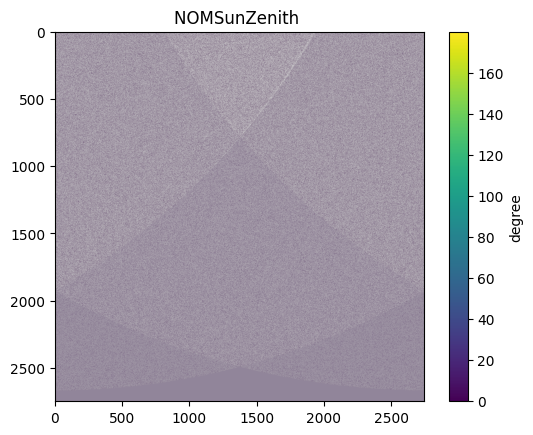

[[          nan 1.0907348e+01           nan ...           nan
            nan 3.2918501e+00]
 [1.3866597e-32           nan           nan ...           nan
            nan 3.4100764e+00]
 [          nan           nan 3.7196189e-31 ...           nan
            nan 3.5141294e+00]
 ...
 [          nan 1.0907348e+01           nan ... 1.0907348e+01
            nan 1.0907348e+01]
 [          nan 1.0907348e+01           nan ... 1.0907348e+01
            nan 1.0907348e+01]
 [          nan 1.0907348e+01           nan ... 1.0907348e+01
            nan 1.0907348e+01]]


In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

hdf_file = "D:/SCJW/baseR/SCJW_FY4B/data/FY4B_GEO_FIXED_20240227000000.hdf"

with h5py.File(hdf_file, 'r') as f:
    sun_zenith = f['Navigation/NOMSunZenith'][:]
    plt.imshow(sun_zenith, cmap='viridis')
    plt.title("NOMSunZenith ")
    plt.colorbar(label="degree")
    plt.show()

print( sun_zenith )

In [27]:
import h5py
import numpy as np

geo_hdf = "D:/SCJW/baseR/SCJW_FY4B/data/FY4B_GEO_FIXED_20240227000000.hdf"
with h5py.File(geo_hdf, 'r') as fgeo:
    LAT = fgeo['Data/Latitude'][:]
    LON = fgeo['Data/Longitude'][:]
    SUN_ZEN = fgeo['Navigation/NOMSunZenith'][:]
    # 可根据需要加 NOMSunAzimuth, NOMSatelliteZenith 等
print("GEO数据 shape:", LAT.shape, LON.shape, SUN_ZEN.shape)


GEO数据 shape: (2748, 2748) (2748, 2748) (2748, 2748)


## 关于异常热点的计算
风云4B没有标准方法，目前文献的方法是：

1. **《基于FY-3D\_MERSI数据的火点识别方法研究》（殷针针）**
2. **《基于FY4遥感数据的森林火灾判别研究》（熊得祥）**
3. **《基于风云卫星数据的火情监测研究》**

我归纳出一套系统的 **FY-4B 异常热点识别流程与计算方法**，如下所示：

---

##  FY-4B 异常热点识别方法（基于红外通道与太阳天顶角）

###  1. **选择通道**

根据文献及 FY-4B 数据说明，主要用于火点识别的波段：

| 通道名称                     | 中心波长    | 说明              |
| ------------------------ | ------- | ----------------- |
| **NOMChannel04 (3.7μm)** | 3.7 µm  | **火点检测主波段**，灵敏于高温 |
| NOMChannel05 (10.8μm)    | 10.8 µm | 夜间背景温度估计          |
| NOMChannel06 (12.0μm)    | 12.0 µm | 白天大气校正辅助          |
| 可选通道：Channel01-03（可见光）   |         | 白天辅助识别（云、烟）       |

---

###  2. **火点判别规则（亮温阈值 + 空间差异）**

#### **2.1 基本亮温阈值法（白天 + 夜间）**
根据火点亮温的典型特征设置温度下限：

| 场景                 | 判别条件示例（亮温单位：K）                    |
| ------------------ | --------------------------------- |
| **夜间（无太阳干扰）**      | BT(3.7µm) ≥ 315\~330K（部分文献用 320K） |
| **白天（需排除太阳高角度影响）** | BT(3.7µm) ≥ 340K 且 太阳天顶角 > 110°   |

> Note：白天时太阳反射会干扰 3.7µm 通道，因此要结合太阳天顶角（`SunZenith`）进行筛除。

#### **2.2 空间差异法（空间异常检测）**

进一步考虑像元与其周围邻域的亮温差异：
* 以 3×3 或 5×5 滑动窗口提取：

  ```python
  ΔT = BT_center - max(BT_neighbors)  # 或均值
  ```
* 设置差异阈值：

  ```text
  ΔT > 10K 或 ΔT > 15K 判为热点
  ```

---

### ✅ 3. **火点掩膜构建与输出（示意逻辑）**

```python
hot_mask = (
    (BT_3p7 >= 330) & 
    (sun_zenith > 110) & 
    (ΔT > 10)  # 可以作为条件之一 可以删除
)
```

输出火点位置：

```python
hot_lat = lat[hot_mask]
hot_lon = lon[hot_mask]
```

---

## 文献中具体使用的参数

| 文献标题            | 通道    | 判别条件                    | 特别说明      |
| --------------- | ----- | ----------------------- | --------- |
| **《FY-3D火点识别》** | 3.7µm | BT > 315K（夜间）           | 昼夜分离判别    |
| **《FY4火灾判别》**   | 3.7µm | BT > 340K 且太阳天顶角 > 110° | 加权区域最大温差法 |
| **《FY火情监测研究》**  | 3.7µm | ΔT > 10K                | 邻域窗口差异法   |

---

## 我现在可以实现的火点识别流程（Python）

1. **读取 3.7μm 波段亮温**（如 `NOMChannel04`）
2. **读取 GEO 文件中 `Latitude`, `Longitude`, `SunZenith`**
3. **应用亮温和太阳角度阈值筛选**
4. **加入滑动窗口提取 ΔT 并做空间异常差异判断** 有点麻烦 计算量相对大
5. **输出火点经纬度或掩膜图像**


Grid size: 1600 900
IR [[3919. 3937. 3943. ... 3985. 3960. 3972.]
 [3966. 3940. 3943. ... 3985. 3972. 3972.]
 [4010. 3954. 3933. ... 3979. 3972. 3956.]
 ...
 [3944. 3947. 3946. ... 3954. 3911. 3911.]
 [3948. 3947. 3945. ... 3954. 3902. 3911.]
 [3945. 3949. 3944. ... 3920. 3902. 3902.]]
（IR）shape: (1600, 900)
min: 0.03631512215360999 max: 1.7348481812514365


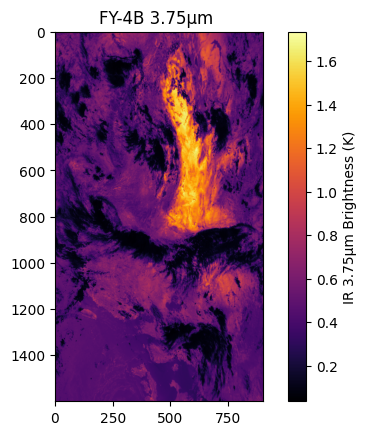

In [51]:
import h5py
import numpy as np
import math
from numpy import deg2rad, rad2deg, arctan, arcsin, tan, sqrt, cos, sin

# ===== 基础参数 =====
data_file = 'D:/SCJW/baseR/SCJW_FY4B/data/Z_SATE_C_BAWX_20250630050227_P_FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250630044500_20250630045959_4000M_V0001.HDF'

ea = 6378.137  # 地球的半长轴[km]
eb = 6356.7523  # 地球的短半轴[km]
h = 42164      # 地心到卫星质心的距离[km]
λD = deg2rad(105)  # 卫星星下点经度

COFF = {"4000M": 1373.5}
CFAC = {"4000M": 10233137}
LOFF = COFF
LFAC = CFAC

def latlon2linecolumn(lat, lon, resolution):
    lat = deg2rad(lat)
    lon = deg2rad(lon)
    eb2_ea2 = eb ** 2 / ea ** 2
    λe = lon
    φe = arctan(eb2_ea2 * tan(lat))
    cosφe = cos(φe)
    re = eb / sqrt(1 - (1 - eb2_ea2) * cosφe ** 2)
    λe_λD = λe - λD
    r1 = h - re * cosφe * cos(λe_λD)
    r2 = -re * cosφe * sin(λe_λD)
    r3 = re * sin(φe)
    rn = sqrt(r1 ** 2 + r2 ** 2 + r3 ** 2)
    x = rad2deg(arctan(-r2 / r1))
    y = rad2deg(arcsin(-r3 / rn))
    column = COFF[resolution] + x * 2 ** -16 * CFAC[resolution]
    line = LOFF[resolution] + y * 2 ** -16 * LFAC[resolution]
    return np.rint(line).astype(np.uint16), np.rint(column).astype(np.uint16)

# ===== 网格参数（中国区） =====
x_min = 18
x_max = 54
y_min = 72
y_max = 136
step = 0.04

column = math.ceil((x_max - x_min) / step)
row = math.ceil((y_max - y_min) / step)
print('Grid size:', row, column)

ynew = np.linspace(y_min, y_max, row)
xnew = np.linspace(x_min, x_max, column)
xnew, ynew = np.meshgrid(xnew, ynew)

data_grid = np.zeros((row, column))

# ===== 读取 HDF5 文件，提取/定标 NOMChannel07 =====
wanted_channel = 'NOMChannel07'

with h5py.File(data_file, 'r') as f_data:
    value = f_data['Data'][wanted_channel][:]
    # 校准参数（3.75μm通道在第6个索引，索引从0计数）
    calib_coef = f_data['Calibration/CALIBRATION_COEF(SCALE+OFFSET)'][:]
    slope = calib_coef[6, 0]
    intercept = calib_coef[6, 1]

    # 逐点采样
    index = {}
    for i in range(row):
        for j in range(column):
            lat = xnew[i][j]
            lon = ynew[i][j]
            if index.get((lat, lon)) is None:
                fy_line, fy_column = latlon2linecolumn(lat, lon, "4000M")
                index[(lat, lon)] = fy_line, fy_column
            else:
                fy_line, fy_column = index.get((lat, lon))
            # 数据越界保护
            if 0 <= fy_line < value.shape[0] and 0 <= fy_column < value.shape[1]:
                data_grid[i][j] = value[fy_line, fy_column]
            else:
                data_grid[i][j] = np.nan
    # 定标
    IR = data_grid * slope + intercept

print("IR", data_grid)
print("（IR）shape:", IR.shape)
print("min:", np.nanmin(IR), "max:", np.nanmax(IR))

# ======= 作个图 =======
import matplotlib.pyplot as plt
plt.imshow(IR, cmap='inferno')
plt.colorbar(label='IR 3.75μm Brightness (K)')
plt.title('FY-4B 3.75μm ')
plt.show()


Grid size: 1600 900


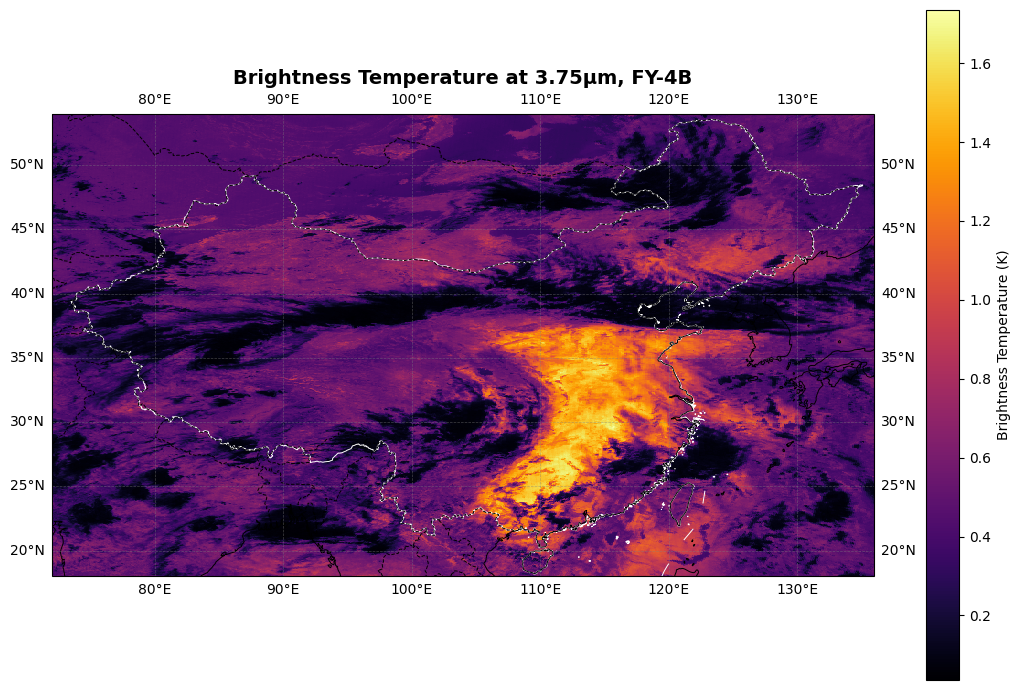

In [ ]:
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from numpy import deg2rad, rad2deg, arctan, arcsin, tan, sqrt, cos, sin

# ===== 基础参数 =====
data_file = 'D:/SCJW/baseR/SCJW_FY4B/data/Z_SATE_C_BAWX_20250630050227_P_FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250630044500_20250630045959_4000M_V0001.HDF'
china_province_shapefile = 'D:/SCJW/baseR/SCJW_FY4B/data/中国轮廓线.shp'

ea = 6378.137
eb = 6356.7523
h = 42164
λD = deg2rad(105)

COFF = {"4000M": 1373.5}
CFAC = {"4000M": 10233137}
LOFF = COFF
LFAC = CFAC

def latlon2linecolumn(lat, lon, resolution):
    lat = deg2rad(lat)
    lon = deg2rad(lon)
    eb2_ea2 = eb ** 2 / ea ** 2
    λe = lon
    φe = arctan(eb2_ea2 * tan(lat))
    cosφe = cos(φe)
    re = eb / sqrt(1 - (1 - eb2_ea2) * cosφe ** 2)
    λe_λD = λe - λD
    r1 = h - re * cosφe * cos(λe_λD)
    r2 = -re * cosφe * sin(λe_λD)
    r3 = re * sin(φe)
    rn = sqrt(r1 ** 2 + r2 ** 2 + r3 ** 2)
    x = rad2deg(arctan(-r2 / r1))
    y = rad2deg(arcsin(-r3 / rn))
    column = COFF[resolution] + x * 2 ** -16 * CFAC[resolution]
    line = LOFF[resolution] + y * 2 ** -16 * LFAC[resolution]
    return np.rint(line).astype(np.uint16), np.rint(column).astype(np.uint16)

# ===== 网格参数（中国区） =====
x_min, x_max = 18, 54
y_min, y_max = 72, 136
step = 0.04

column = math.ceil((x_max - x_min) / step)
row = math.ceil((y_max - y_min) / step)
print('Grid size:', row, column)

ynew = np.linspace(y_min, y_max, row)
xnew = np.linspace(x_min, x_max, column)
xnew, ynew = np.meshgrid(xnew, ynew)

data_grid = np.zeros((row, column))

# ===== 读取 HDF5 文件，提取/定标 NOMChannel07 =====
wanted_channel = 'NOMChannel07'
with h5py.File(data_file, 'r') as f_data:
    value = f_data['Data'][wanted_channel][:]
    calib_coef = f_data['Calibration/CALIBRATION_COEF(SCALE+OFFSET)'][:]
    slope = calib_coef[6, 0]
    intercept = calib_coef[6, 1]
    index = {}
    for i in range(row):
        for j in range(column):
            lat = xnew[i][j]
            lon = ynew[i][j]
            if index.get((lat, lon)) is None:
                fy_line, fy_column = latlon2linecolumn(lat, lon, "4000M")
                index[(lat, lon)] = fy_line, fy_column
            else:
                fy_line, fy_column = index.get((lat, lon))
            if 0 <= fy_line < value.shape[0] and 0 <= fy_column < value.shape[1]:
                data_grid[i][j] = value[fy_line, fy_column]
            else:
                data_grid[i][j] = np.nan
    IR = data_grid * slope + intercept

# ======= 可视化 =======
fig = plt.figure(figsize=(11, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
im = ax.imshow(IR, extent=[y_min, y_max, x_min, x_max], origin='lower', cmap='inferno', interpolation='nearest')
ax.set_title('Brightness Temperature at 3.75μm, FY-4B', fontsize=14, fontweight='bold')
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
plt.colorbar(im, ax=ax, label='Brightness Temperature (K)')

# 加中国省界
reader = shpreader.Reader(china_province_shapefile)
for record in reader.records():
    geom = record.geometry
    ax.add_geometries([geom], ccrs.PlateCarree(), edgecolor='white', facecolor='none', linewidth=0.7)

ax.set_extent([y_min, y_max, x_min, x_max], crs=ccrs.PlateCarree())
ax.coastlines('50m', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.7)
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()



上面能正常计算亮温后，把其他计算方法插入用来识别异常热点，这里不用时间窗的算法。把GEO数据中的太阳天顶角矫正处理出来(数据暂时没有)：

经纬度 shape: (2748, 2748), (2748, 2748), 太阳天顶角 shape: (2748, 2748)
[[          nan 1.0907348e+01           nan ...           nan
            nan 3.2918501e+00]
 [1.3866597e-32           nan           nan ...           nan
            nan 3.4100764e+00]
 [          nan           nan 3.7196189e-31 ...           nan
            nan 3.5141294e+00]
 ...
 [          nan 1.0907348e+01           nan ... 1.0907348e+01
            nan 1.0907348e+01]
 [          nan 1.0907348e+01           nan ... 1.0907348e+01
            nan 1.0907348e+01]
 [          nan 1.0907348e+01           nan ... 1.0907348e+01
            nan 1.0907348e+01]]
✅ 检测到 0 个热点，已导出为 CSV


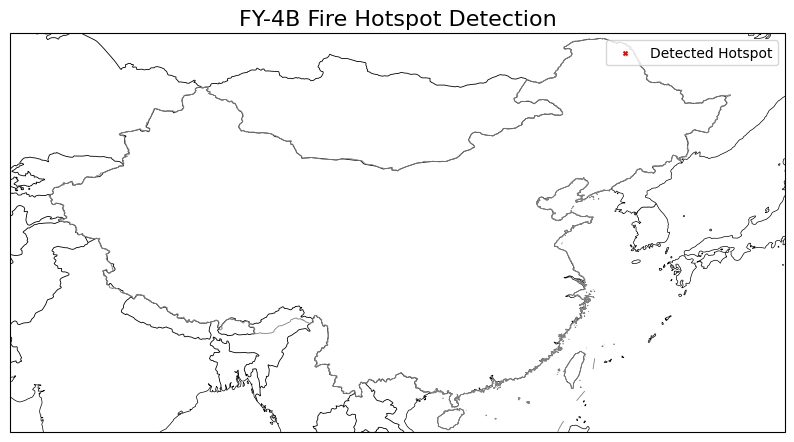

In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math 
from numpy import deg2rad, rad2deg, arctan, arcsin, tan, sqrt, cos, sin

# =================== 1. 读取数据 ====================
#  GEO HDF（含经纬度和太阳天顶角）
geo_file = 'D:/SCJW/baseR/SCJW_FY4B/data/FY4B_GEO_FIXED_20240227000000.hdf'
data_file = 'D:/SCJW/baseR/SCJW_FY4B/data/Z_SATE_C_BAWX_20250630050227_P_FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250630044500_20250630045959_4000M_V0001.HDF'

# 读取经纬度和太阳天顶角
with h5py.File(geo_file, 'r') as f:
    lat = f['Data/Latitude'][:]
    lon = f['Data/Longitude'][:]
    sun_zenith = f['Navigation/NOMSunZenith'][:]
    # 剔除无效
    lat[(lat < -90) | (lat > 90)] = np.nan
    lon[(lon < 70) | (lon > 140)] = np.nan  # 全球用(-180,180)
    sun_zenith[(sun_zenith < 0) | (sun_zenith > 180)] = np.nan
print(f"经纬度 shape: {lat.shape}, {lon.shape}, 太阳天顶角 shape: {sun_zenith.shape}")
print(sun_zenith)
# 读取3.75μm热红外通道，并用定标系数转亮温
with h5py.File(data_file, 'r') as f:
    IR = f['Data/NOMChannel07'][:]
    calib_coef = f['Calibration/CALIBRATION_COEF(SCALE+OFFSET)'][:]
    slope = calib_coef[6, 0]
    intercept = calib_coef[6, 1]
    BT = IR * slope + intercept

# =================== 2. 异常值处理 ====================
invalid = (BT < 180) | (BT > 400) | np.isnan(lat) | np.isnan(lon) | np.isnan(sun_zenith)
BT[invalid] = np.nan
lat[invalid] = np.nan
lon[invalid] = np.nan
sun_zenith[invalid] = np.nan





# =================== 3. 火点判别  ====================
BT_thresh = 315      # 亮温阈值（根据文献）
SZA_thresh = 110      # 太阳天顶角
hotspot_mask = (BT > BT_thresh) & (sun_zenith > SZA_thresh) & (~np.isnan(BT))

# =================== 4. 输出为CSV ====================
hot_lat = lat[hotspot_mask]
hot_lon = lon[hotspot_mask]
hot_BT = BT[hotspot_mask]
hot_SZA = sun_zenith[hotspot_mask]
out = pd.DataFrame({
    'Latitude': hot_lat,
    'Longitude': hot_lon,
    'BrightnessTemp_K': hot_BT,
    'SunZenith_deg': hot_SZA,
})
out.to_csv('FY4B_hotspots_detected.csv', index=False, float_format='%.5f')
print(f"✅ 检测到 {len(out)} 个热点，已导出为 CSV")

# =================== 5. 可视化地图叠加 ====================
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([70, 140, 18, 54], ccrs.PlateCarree())  # 中国范围
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
# 加省界
try:
    china_province_shapefile = 'D:/SCJW/baseR/SCJW_FY4B/data/中国轮廓线.shp'
    import cartopy.io.shapereader as shpreader
    reader = shpreader.Reader(china_province_shapefile)
    for rec in reader.records():
        geom = rec.geometry
        ax.add_geometries([geom], ccrs.PlateCarree(), edgecolor='gray', facecolor='none', linewidth=0.6)
except Exception as e:
    print(f"⚠️ 无法加载shapefile: {e}")

# 画所有热点
ax.scatter(hot_lon, hot_lat, c='red', s=8, marker='x', label='Detected Hotspot', zorder=10)
ax.set_title("FY-4B Fire Hotspot Detection", fontsize=16)
ax.legend(loc='upper right')
plt.show()


In [10]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import generic_filter
from numpy import deg2rad, tan, arctan, sqrt, cos, sin

# =================== 1. 常量定义 ====================
# 地球参数 (FY-4B全局属性)
EARTH_SEMI_MAJOR = 6378137.0     # 地球长半轴 [m]
EARTH_SEMI_MINOR = 6356752.31414  # 地球短半轴 [m]
SAT_HEIGHT = 42164000             # 卫星高度 [m] (静止轨道)
SUB_LON = 105.0                   # 星下点经度 [°] (FY-4B位置)

# 火点检测阈值 (论文公式)
T7_ABSOLUTE_THRESH = 300          # 3.75μm通道绝对温度阈值 [K]
VIS_REFL_THRESH = 0.7             # 可见光反射率阈值
SUN_ZENITH_THRESH = 3             # 最小太阳天顶角 [°]
BTD_THRESH_BASE = 5            # 基础亮温差阈值 [K]
REFL_ADJUST_FACTOR = 100          # 反射率调整因子

# 中国区域范围
LAT_MIN = 18.0
LAT_MAX = 54.0
LON_MIN = 72.0
LON_MAX = 136.0

# =================== 2. 辅助函数 ====================
def dn_to_reflectance(dn, scale, offset):
    """DN值转反射率 (公式1)"""
    return dn * scale + offset

def dn_to_radiance(dn, scale, offset):
    """DN值转辐射亮度 (热红外通道)"""
    return dn * scale + offset

def radiance_to_bt(radiance, wavelength):
    """辐射亮度转亮温 (普朗克反演)"""
    # 添加小量防止log(0)错误
    radiance = np.maximum(radiance, 1e-10)
    
    c1 = 1.19104e8   # W/(m²·sr·μm⁴)
    c2 = 14387.8     # μm·K
    
    # 避免除以零和无效值
    with np.errstate(divide='ignore', invalid='ignore'):
        bt = c2 / (wavelength * np.log(c1 / (wavelength**5 * radiance) + 1))
    
    return np.where(np.isfinite(bt), bt, np.nan)

def adjust_reflectance(refl, sza):
    """反射率太阳天顶角校正 (公式2)"""
    # 过滤无效太阳天顶角
    valid_sza = np.where(sza >= 0, sza, np.nan)
    sza_rad = deg2rad(valid_sza)
    
    # 安全计算调整因子
    with np.errstate(invalid='ignore'):
        adjustment = np.cos(sza_rad * (1.0 - 1.3 * np.sin(0.05 * sza_rad)))
    
    # 避免除以零
    adjustment = np.where(adjustment > 0.1, adjustment, 0.1)
    
    return refl / adjustment

def compute_geocentric_lat(lat):
    """计算地心纬度 (公式4)"""
    lat_rad = deg2rad(lat)
    return np.arctan((EARTH_SEMI_MINOR**2 / EARTH_SEMI_MAJOR**2) * np.tan(lat_rad))

def compute_projection_distance(phi_e):
    """计算投影距离 (公式5)"""
    ecc_sq = (EARTH_SEMI_MAJOR**2 - EARTH_SEMI_MINOR**2) / EARTH_SEMI_MAJOR**2
    return EARTH_SEMI_MINOR / np.sqrt(1 - ecc_sq * np.cos(phi_e)**2)

# =================== 3. 主处理流程 ====================
def detect_hotspots(geo_file, data_file, output_csv, output_plot):
    # =================== 3.1 读取GEO数据 ====================
    with h5py.File(geo_file, 'r') as f:
        lat = f['Data/Latitude'][:]
        lon = f['Data/Longitude'][:]
        sun_zenith = f['Navigation/NOMSunZenith'][:]
        
        # 无效值处理
        lat = np.where((lat >= -90) & (lat <= 90), lat, np.nan)
        lon = np.where((lon >= -180) & (lon <= 180), lon, np.nan)
        sun_zenith = np.where((sun_zenith >= 0) & (sun_zenith <= 180), sun_zenith, np.nan)
    
    # 创建中国区域掩膜
    china_mask = (
        (lat >= LAT_MIN) & (lat <= LAT_MAX) & 
        (lon >= LON_MIN) & (lon <= LON_MAX)
    )
    
    # =================== 3.2 读取L1数据并定标 ====================
    with h5py.File(data_file, 'r') as f:
        # 读取可见光通道 (0.65μm)
        vis_dn = f['Data/NOMChannel02'][:]
        # 读取红外通道
        ch07_dn = f['Data/NOMChannel07'][:]  # 3.75μm
        ch13_dn = f['Data/NOMChannel13'][:]  # 10.8μm
        
        # 获取定标系数
        calib_coef = f['Calibration/CALIBRATION_COEF(SCALE+OFFSET)'][:]
        # 通道2 (可见光) 定标系数
        vis_scale = calib_coef[1, 0]  # 索引1对应通道2
        vis_offset = calib_coef[1, 1]
        # 通道7 (3.75μm) 定标系数
        ch07_scale = calib_coef[6, 0]  # 索引6对应通道7
        ch07_offset = calib_coef[6, 1]
        # 通道13 (10.8μm) 定标系数
        ch13_scale = calib_coef[12, 0]  # 索引12对应通道13
        ch13_offset = calib_coef[12, 1]
    
    # 定标转换
    vis_refl = dn_to_reflectance(vis_dn, vis_scale, vis_offset)
    vis_refl_adj = adjust_reflectance(vis_refl, sun_zenith)  # 太阳天顶角校正
    
    # 计算亮温
    ch07_rad = dn_to_radiance(ch07_dn, ch07_scale, ch07_offset)
    ch13_rad = dn_to_radiance(ch13_dn, ch13_scale, ch13_offset)
    bt_07 = radiance_to_bt(ch07_rad, 3.75)  # 3.75μm亮温
    bt_13 = radiance_to_bt(ch13_rad, 10.8)  # 10.8μm亮温
    
    # =================== 3.3 火点识别 ====================
    # 步骤1: 疑似火点判断 (论文公式12)
    btd_thresh = BTD_THRESH_BASE + REFL_ADJUST_FACTOR * vis_refl_adj
    potential_hotspots = (bt_07 >= bt_13 + btd_thresh)
    
    # 步骤2: 绝对条件过滤 (论文公式15)
    absolute_conditions = (
        (bt_07 > T7_ABSOLUTE_THRESH) &
        (vis_refl_adj < VIS_REFL_THRESH) &
        (sun_zenith > SUN_ZENITH_THRESH)
    )
    
    # 步骤3: 云污染过滤 (论文公式17)
    def background_mean(window):
        # 忽略NaN值计算均值
        valid_vals = window[~np.isnan(window)]
        return np.mean(valid_vals) if len(valid_vals) > 0 else np.nan
    
    # 计算3.75μm背景亮温 (5×5窗口)
    bt_07_bg = generic_filter(bt_07, background_mean, size=5, mode='nearest')
    # 计算亮温差背景
    btd_bg = generic_filter(bt_07 - bt_13, background_mean, size=5, mode='nearest')
    
    # 云污染阈值
    cloud_contam = (vis_refl_adj > 0.5) & (bt_13 < bt_07_bg - 5)
    
    # 最终火点掩膜 (只考虑中国区域)
    hotspot_mask = potential_hotspots & absolute_conditions & ~cloud_contam & china_mask
    
    # =================== 3.4 明火面积估算 ====================
    def compute_fire_area(L_mix, L_bg, wavelength, T_f=750):
        """计算明火面积 (论文公式22-24)"""
        # 计算火点辐射亮度 (750K)
        L_fire = 1.19104e8 / (wavelength**5 * (np.exp(14387.8/(wavelength*T_f)) - 1))
        
        # 避免除以零或负值
        denominator = np.maximum(L_fire - L_bg, 1e-10)
        P = (L_mix - L_bg) / denominator
        
        # 计算明火面积 (像元面积=16km²)
        return np.clip(P, 0, 1) * 16  # km²
    
    # 计算3.75μm背景辐射亮度
    ch07_rad_bg = generic_filter(ch07_rad, background_mean, size=5, mode='nearest')
    
    # 估算明火面积
    fire_area = np.zeros_like(ch07_rad)
    valid_fire = hotspot_mask & ~np.isnan(ch07_rad_bg)
    
    fire_area[valid_fire] = compute_fire_area(
        ch07_rad[valid_fire], 
        ch07_rad_bg[valid_fire],
        3.75
    )
    
    # =================== 3.5 结果输出 ====================
    hotspot_idx = np.where(hotspot_mask & (fire_area > 0))
    hotspot_data = pd.DataFrame({
        'Latitude': lat[hotspot_idx],
        'Longitude': lon[hotspot_idx],
        'BT_3.75um': bt_07[hotspot_idx],
        'BT_10.8um': bt_13[hotspot_idx],
        'BTD': bt_07[hotspot_idx] - bt_13[hotspot_idx],
        'Vis_Reflectance': vis_refl_adj[hotspot_idx],
        'Fire_Area_km2': fire_area[hotspot_idx],
        'Sun_Zenith': sun_zenith[hotspot_idx]
    })
    
    # 过滤掉无效值
    hotspot_data = hotspot_data.dropna()
    hotspot_data.to_csv(output_csv, index=False)
    
    # =================== 3.6 可视化 ====================
    plot_results(lon, lat, hotspot_data, output_plot)
    
    print(f"🔥 检测到 {len(hotspot_data)} 个热点 | 最大明火面积: {hotspot_data['Fire_Area_km2'].max():.2f} km²")
    return hotspot_data

def plot_results(lon, lat, hotspots, output_path):
    """可视化火点检测结果"""
    plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # 设置中国区域范围
    ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX], ccrs.PlateCarree())
    
    # 添加地理要素
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS, linewidth=0.5)
    
    # 添加省界
    provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )
    ax.add_feature(provinces, edgecolor='gray', linewidth=0.5)
    
    # 添加火点 (按面积大小渲染)
    if len(hotspots) > 0:
        scatter = ax.scatter(
            hotspots['Longitude'],
            hotspots['Latitude'],
            c=hotspots['BT_3.75um'],
            s=np.clip(hotspots['Fire_Area_km2'] * 20, 10, 500),  # 面积缩放因子
            cmap='hot_r',
            vmin=350,
            vmax=450,
            alpha=0.7,
            transform=ccrs.PlateCarree(),
            edgecolors='k',
            linewidths=0.3
        )
        
        # 添加色标
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
        cbar.set_label('3.75μm Brightness Temperature (K)')
    
    # 添加标题
    plt.title(f'FY-4B AGRI Fire Hotspot Detection in China\n{len(hotspots)} Hotspots Identified', fontsize=16)
    
    # 添加网格
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # 保存结果
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

# =================== 4. 执行主函数 ====================
if __name__ == "__main__":
    # 输入文件
    geo_file = 'D:/SCJW/baseR/SCJW_FY4B/data/FY4B_GEO_FIXED_20240227000000.hdf'
    data_file = 'D:/SCJW/baseR/SCJW_FY4B/data/Z_SATE_C_BAWX_20250630050227_P_FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250630044500_20250630045959_4000M_V0001.HDF'

    # 输出文件
    output_csv = 'FY4B_hotspots_results.csv'
    output_plot = 'FY4B_hotspots_map.png'
    
    # 执行检测
    hotspots = detect_hotspots(geo_file, data_file, output_csv, output_plot)

🔥 检测到 0 个热点 | 最大明火面积: nan km²
